In [1]:
import numpy as np
import networkx as nx
from collections import Counter
from kervis.dataset import Dataset
from kervis.kernels import ShortestPath as kervis_ShortestPath

from kervis.utils import fetch_dataset
from grakel.kernels import ShortestPath as grakel_ShortestPath

In [2]:
G1 = nx.Graph()
G1.add_node(0, label=0)
G1.add_node(1, label=0)
G1.add_node(2, label=0)
G1.add_node(3, label=0)
G1.add_node(4, label=1)
G1.add_node(5, label=1)
G1.add_node(6, label=1)
G1.add_edges_from([
     (0,3),
     (1,3),
     (2,3),
     (3,4),
     (4,5),
     (4,6)])

G2 = nx.Graph()
G2.add_node(7, label=0)
G2.add_node(8, label=0)
G2.add_node(9, label=0)
G2.add_node(10, label=0)
G2.add_node(11, label=1)
G2.add_node(12, label=1)
G2.add_node(13, label=1)
G2.add_edges_from([
     (7,10),
     (8,10),
     (9,10),
     (10,11),
     (11,12),
     (11,13),
     (7,12),
     (9,13)])

G = [G1, G2]

a = [[{(0,3),
     (1,3),
     (2,3),
     (3,4),
     (4,5),
     (4,6)},
    {0:0,
     1:0,
     2:0,
     3:0,
     4:1,
     5:1,
     6:1},
    {}],
    [{(7,10),
     (8,10),
     (9,10),
     (10,11),
     (11,12),
     (11,13),
     (7,12),
     (9,13)},
    {7:0,
     8:0,
     9:0,
     10:0,
     11:1,
     12:1,
     13:1},
    {}]]

In [3]:
SP = kervis_ShortestPath()
lengths, lengths_with_labels = SP.fit_transform(G)

SP_grakel = grakel_ShortestPath()
fitted = SP_grakel.fit_transform(a)

In [4]:
index = 0
print(list(Counter(lengths_with_labels[index]).values()))
print(SP_grakel._phi_X[index])

[6, 1, 2, 3, 1, 5, 3]
[3. 5. 6. 1. 2.]


[1, 22, 1, 4, 22, 16, 2, 4, 10, 16, 2, 2, 4, 4, 2, 4, 2, 4, 2, 4, 2, 2, 1, 1, 2]
[32, 44, 44, 32, 20, 8, 2, 1, 2, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 4, 4, 4, 4, 4, 4, 2, 2, 2]


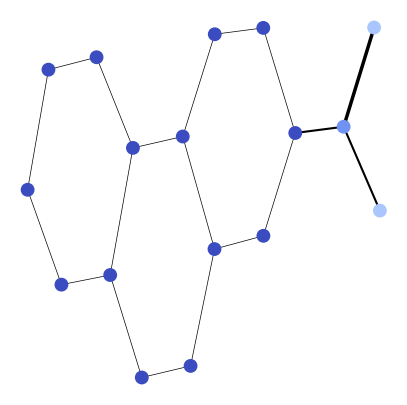

In [5]:
dataset_nx = Dataset("MUTAG")
lengths, lengths_with_labels = SP.fit_transform(dataset_nx.graphs)

dataset_gk = fetch_dataset("MUTAG", verbose=False).data
fitted = SP_grakel.fit_transform(dataset_gk)

index = 0
print(list(Counter(lengths_with_labels[index]).values()))
print([int(count) for count in SP_grakel._phi_X[index] if count != 0])
dataset_nx.plot_graph(0)

In [7]:
Counter(lengths_with_labels[index])

Counter({(0, 1, 1): 1,
         (0, 0, 3): 22,
         (0, 1, 8): 1,
         (0, 2, 6): 4,
         (0, 0, 2): 22,
         (0, 0, 1): 16,
         (0, 1, 2): 2,
         (0, 2, 8): 4,
         (0, 0, 5): 10,
         (0, 0, 4): 16,
         (0, 2, 2): 2,
         (0, 2, 9): 2,
         (0, 2, 5): 4,
         (0, 0, 6): 4,
         (0, 1, 5): 2,
         (0, 2, 7): 4,
         (0, 1, 7): 2,
         (0, 2, 4): 4,
         (1, 2, 1): 2,
         (0, 2, 3): 4,
         (0, 1, 6): 2,
         (0, 1, 4): 2,
         (0, 0, 7): 1,
         (2, 2, 2): 1,
         (0, 1, 3): 2})